# Convolutional Neural Networks

# **Assignment 2**
### 10 Points

---

#### The lab has two parts. 

The first part of the lab acts as a tutorial for you to get familiar with PyTorch CNN. 

In the second part you will have to do some real coding:


1. Construct a CNN model. [1 point]

2. Define the Loss, training device, and any hyperparameters that you wish to tune. [1 point]

3. Define a training function that trains the model using training set and test it with testing set. [2 points]

4. Train the customized model on CIFAR-10 dataset and ensure the model is trained correctly (fine-tune). [2 points]

5. Visualize the loss and accuracy of the model. [1 point]

6. Load a pre-trained CNN model and freeze the pre-trained weights. [1 point]

7. Replace the final classifier layer (Linear layer) to match the number of classes in the dataset. [1 point]

8. Train the pre-trained model and visualize the accuracy and loss. [1 point]
---



This lab expects a basic understanding of pytorch and convolutional networks.

* `torch.nn` documentation http://pytorch.org/docs/master/nn.html
* Convolution animations. Make sure to understand these animations so you can visualize stride, padding, etc. https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* If you want to look at something more complicated, check out the ResNet implementation in torchvision: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [1]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets

## Data Format

Dimension ordering is very important. For pytorch:

* 2D data like images should be `(samples, channels, height, width)` sometimes called "NCHW" or "channels first"
* 1D data like stock prices should be `(samples, channels, time)`
* 2D filters should be `(out_channels, in_channels, height, width)`
* 1D filters should be `(out_channels, in_channels, time)`

Different frameworks (e.g., TensorFlow) use different dimension orderings so be very careful, especially when implementing code or reading data targeted at a different framework.

Note most image data is RGB but some is BGR  or ARGB.

In [2]:
input_image = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(input_image.size())
input_signal = autograd.Variable(torch.randn(1,40,100)) # 40 dimensional signal for 100 timesteps
print(input_signal.size())

torch.Size([1, 3, 32, 32])
torch.Size([1, 40, 100])


## Convolutional Layers

The `torch.nn` module provides layers for CNNs. Use in the same way as other modules. Please refer to the documentation for details. Some of the most common layers you will use:

* `torch.nn.Conv2d`
* `torch.nn.ConvTranspose2d`
* `torch.nn.MaxPool2d`
* `torch.nn.AvgPool2d`


In [3]:
# Create layers
layer_c2d = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2)
layer_avg = torch.nn.AvgPool2d(kernel_size=32)

In [4]:
# Use layers directly
y = layer_c2d(input_image)
print(y.size())

torch.Size([1, 20, 32, 32])


In [5]:
# Add layers to model
model = torch.nn.Sequential(layer_avg, layer_c2d)
y = model(input_image)
print(y.size())

torch.Size([1, 20, 1, 1])


## Convolutional Functions

The `torch.nn.functional` module provides low-level functions. Depending on what kinds of models you are making, you may never have to use these functions, and use pre-made layers instead. When using the functional module, you need to instantiate parameters yourself.

http://pytorch.org/docs/0.1.12/nn.html#torch-nn-functional

Example low-level functions:

* `F.max_pool2d`
* `F.dropout2d`
* `F.conv2d`

In [6]:
filters = autograd.Variable(torch.randn(20,3,5,5)) # 5x5 filter from 3 dimensions to 20
y=F.conv2d(input_image, filters, padding=2)
print(y.size())

torch.Size([1, 20, 32, 32])


In [7]:
filters = autograd.Variable(torch.randn(256,40,5)) # 5 wide filter from 40 dimensions to 256
y=F.conv1d(input_signal, filters, padding=2)
print(y.size())

torch.Size([1, 256, 100])


For example, if you generate the kernel using a neural network, you will have to use the functional module instead of a standard convolutional layer.

## Padding

Simple 0-padding can be accomplished using the `padding` keyword argument of many functions. Normally, you will be using the same vertical and horizontal padding but you can also pass a tuple `(H,W)`. Padding is applied symmetrically.

In [8]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=0)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=1)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=2)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=3)(inputs).size())
print(torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding=(0,3))(inputs).size())

torch.Size([1, 20, 26, 26])
torch.Size([1, 20, 28, 28])
torch.Size([1, 20, 30, 30])
torch.Size([1, 20, 32, 32])
torch.Size([1, 20, 26, 32])


For more complicated padding, use a padding layer before your convolution.

* Single int: apply to all sides
* tuple (H,W): apply H to top and bottom, W to left and right
* tuple (left, right, top, bottom)

In [9]:
inputs = autograd.Variable(torch.randn(1,3,32,32)) # single 32x32 RGB image
y = torch.nn.Conv2d(3, 20, 7)(torch.nn.ReplicationPad2d(3)(inputs))
print(y.size())

torch.Size([1, 20, 32, 32])


Common padding layers:

* torch.nn.ReplicationPad2d
* torch.nn.ReflectionPad2d
* torch.nn.ZeroPad2d
* torch.nn.ConstantPad2d

## Normalization and Dropout

Don't forget BatchNorm2d and Dropout2d if you want to improve performance!

In [10]:
h = nn.Conv2d(3, 20, 5, padding=2)(input_image)
h = nn.BatchNorm2d(20)(h)
h = F.relu(h)
h = nn.Dropout2d(0.5)(h)
print(h.size())

torch.Size([1, 20, 32, 32])


## Downsampling

You can downsample using pooling operations or strided convolutions.

In [11]:
# Simple pooling operations
print(nn.MaxPool2d(2)(input_image).size())
print(nn.AvgPool2d(2)(input_image).size())

torch.Size([1, 3, 16, 16])
torch.Size([1, 3, 16, 16])


In [12]:
# Strided convolution
layer = torch.nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=2, padding=2)
print(layer(input_image).size())

torch.Size([1, 20, 16, 16])


## Reading Image Data

### The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 

### There are 50000 training images and 10000 test images.

In [13]:
## load training dataset
BATCH_SIZE = 512

Mytransform = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(p=0.3)])

trainset = torchvision.datasets.CIFAR10(root='data/train', train=True,
                                        download=True, transform=Mytransform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

## download and load testing dataset
testset = torchvision.datasets.CIFAR10(root='data/test', train=False,
                                       download=True, transform=Mytransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

print('==>>> total training set number: {}'.format(len(trainset)))
print('==>>> total test set number: {}'.format(len(testset)))

Files already downloaded and verified
Files already downloaded and verified
==>>> total training set number: 50000
==>>> total test set number: 10000


### Visualizing the CIFAR-10 dataset

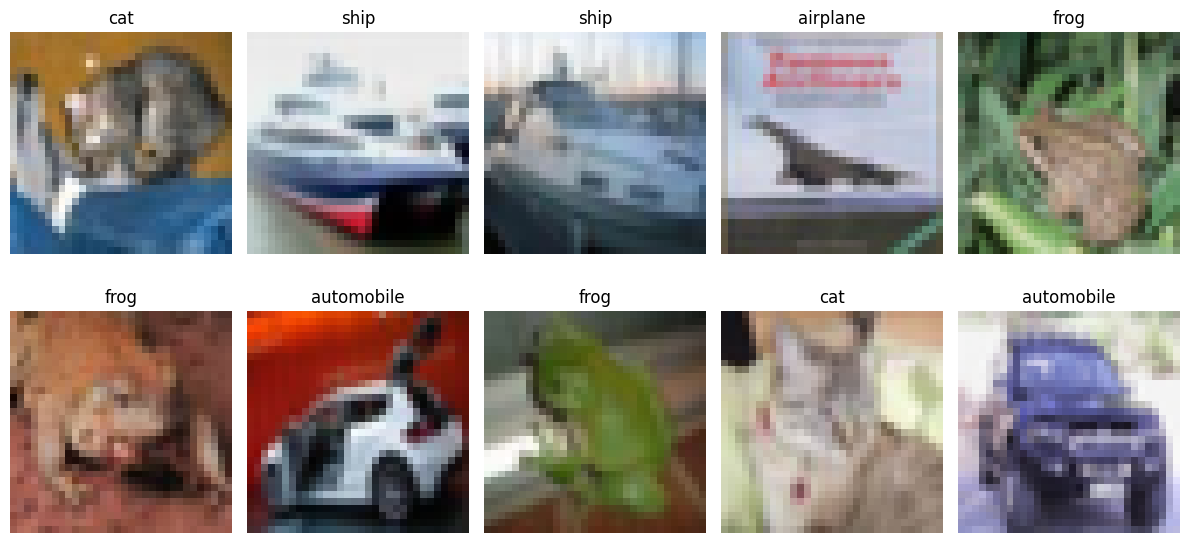

In [14]:
import matplotlib.pyplot as plt

# Define the class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of images from the test dataset
images, labels = next(iter(testloader))

# Plot the images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

# Ensure the loop does not exceed the number of axes available
for i in range(min(len(images), len(axes))):  # This ensures we don't go out of bounds
    image = images[i].numpy().transpose((1, 2, 0))
    # If you've applied normalization, ensure to denormalize the image here
    label = class_labels[labels[i].item()]
    
    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Coding Task 1

## Now write a piece of code to train a CNN Model using CIFAR10 images. 

You are encouraged to reuse your code from Assignment 1.

Another useful blog for this assignment would be https://www.analyticsvidhya.com/blog/2021/09/convolutional-neural-network-pytorch-implementation-on-cifar10-dataset/.


## Define your network architecture. [1 point]

In [15]:
class Mycnn(nn.Module):
    def __init__(self):
        super(Mycnn, self).__init__()
        "YOUR CODE"


    def forward(self, x):
        "YOUR CODE"
        return
    
model = Mycnn()

## Define the Loss, training device, and any hyperparameters that you wish to tune. [1 point]

In [16]:
loss_function = "YOUR CODE"

device = "YOUR CODE"


## Define a training function that trains the model using training set and test it with testing set. [2 points]

In [7]:

"YOUR CODE"

'YOUR CODE'

## Train the customized model on CIFAR-10 dataset and ensure the model is trained correctly (fine-tune). [2 points]

In [6]:
"YOUR CODE"

'YOUR CODE'

## Visualize the loss and accuracy of the model. [1 point]

### Plot the graph of the training accuracy and validation accuracy

In [5]:
"YOUR CODE"

'YOUR CODE'

### Plot the graph of the training loss and validation loss

In [4]:
"YOUR CODE"

'YOUR CODE'

## Pre-trained models

Training CNN models from scratch requires a lot of data. Hence we often use pre-trained models to alleviate this problem. For CNNs, pre-trained models are readily available for famous architectures such as VGG, ResNet and Inception Net.

When you set `pretrained=True`, torchvision automatically downloads the model for you, and initializes weights from there. If this does not work, run the following:
```
>> wget https://download.pytorch.org/models/vgg16-397923af.pth
>> mv vgg16-397923af.pth ~/.torch/models/vgg16-397923af.pth
```

You can find other pretrained models included at https://pytorch.org/docs/stable/torchvision/models.html.

In [21]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True) # this might take a while
vgg16.eval()
print(vgg16)

e:\Anaconda\envs\face_landmark\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\face_landmark\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## We can build a VGG feature extractor. These are often useful in downstream tasks, for example learning deep visual semantic embeddings (https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf). This allows us to use features trained on large datasets like ImageNet, and use on tasks which have lesser data.

## ``` vgg16.features ``` gives us convolutional features. Often, even taking all the layers until the last classification layer also suffices.


In [22]:
vgg16_feature_extractor = vgg16.features
# print('VGG feature extractor', vgg16_feature_extractor)
print(vgg16_feature_extractor(Variable(torch.rand(1, 3, 224, 224))).size())
print(vgg16_feature_extractor(Variable(torch.rand(1, 3, 224, 224))).view(1, -1).size()) # flatten conv features

torch.Size([1, 512, 7, 7])
torch.Size([1, 25088])


# Coding Task 2 

### Please see below the section on Pre-Trained Models and how they can be used as feature extractors. 

### You should now use any pre-trained model such as the one shown below and extract features of an image of your choice and develop a simple  classifer using softmax, MLP or any other one you may want. Keep in mind the input image size before training your model.

A useful blog post for completing this piece of code would be https://medium.com/@tsakunelsonz/loading-and-training-a-neural-network-with-custom-dataset-via-transfer-learning-in-pytorch-8e672933469



## Load a pre-trained CNN model and freeze the pre-trained weights. [1 point]
## Replace the final classifier layer (Linear layer) to match the number of classes in the dataset. [1 point]

In [3]:
"YOUR CODE"

'YOUR CODE'

## Train the pre-trained model and visualize the accuracy and loss. [1 point]

In [ ]:
"YOUR CODE"

### Plot the graph of the training accuracy and validation accuracy

### Plot the graph of the training loss and validation loss

In [1]:
"YOUR CODE"

'YOUR CODE'